In [71]:
import numpy as np
import pandas as pd
import ipaddress
from sklearn.preprocessing import LabelEncoder
from urllib.parse import urlparse
import pyarrow
from ipaddress import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
import re
import warnings
warnings.filterwarnings("ignore")
sns.set_style(style='white') 



In [72]:
# data=pd.read_csv('data_urls.csv')
# data['url'] = data['url'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [73]:
spark=SparkSession.builder.config("spark.driver.host", "localhost").appName('Phishing').getOrCreate()
spark.conf.set("spark.sql.execution.pythonUDF.arrow.enabled", "true")

In [74]:
#  spark.stop()

In [75]:
data=spark.read.csv('data_urls.csv',header=True)

In [76]:
data.show()

+--------------------+------+
|                 url|status|
+--------------------+------+
|0000111servicehel...|     0|
|000011accesswebfo...|     0|
|        00003.online|     0|
|0009servicedeskow...|     0|
|000n38p.wcomhost.com|     0|
|000n38t.wcomhost.com|     0|
|000n8pc.wcomhost.com|     0|
|000ne9r.wcomhost.com|     0|
|000njep.wcomhost.com|     0|
|000nku9.wcomhost.com|     0|
|000nt6r.wcomhost.com|     0|
|000nx2b.wcomhost.com|     0|
|000o1g0.wcomhost.com|     0|
|000o2ba.wcomhost.com|     0|
|000o2sl.wcomhost.com|     0|
|000o4d4.wcomhost.com|     0|
|000o4n8.wcomhost.com|     0|
|000o5eh.wcomhost.com|     0|
|000o8dc.wcomhost.com|     0|
|          001002.xyz|     0|
+--------------------+------+
only showing top 20 rows



In [77]:
data=data.dropDuplicates()
data.show()

+--------------------+------+
|                 url|status|
+--------------------+------+
|            0fj3.icu|     0|
|      103.70.226.173|     0|
|      128.14.128.148|     0|
|     134.209.253.114|     0|
|       139.59.217.81|     0|
|        14.49.36.212|     0|
|       172.94.49.143|     0|
|      178.62.232.170|     0|
|254.38returnfromr...|     0|
|2564548524524154m...|     0|
|2dehands-ibanchec...|     0|
|       46.41.148.232|     0|
|65.254.66.34.bc.g...|     0|
|    a0281074.xsph.ru|     0|
|acount-service.se...|     0|
|   adescottinlaw.com|     0|
|afc2b5fdeb963ec29...|     0|
|  agostin.beget.tech|     0|
|          aideinc.fr|     0|
|amazon.co.jp.amiy...|     0|
+--------------------+------+
only showing top 20 rows



In [81]:
def top_domain(url): 
    try: 
        dom = urlparse(url).netloc
        if dom:
            dom=dom.split('.')[-1]
            return dom
                
        else:
            ind=url.index('/')
            url=url[:ind]
    except:
        pass
    dom=url.split('.')[-1]
    if dom.isdigit():
        dom='0'
    return dom

def domain(url):
    try:
        dom = urlparse(url).netloc
        
        if dom:
            dom=str(dom)
            if re.match(r"^www.",dom):
                dom = dom.replace("www.","")
            dom=dom.split('.')
            dom=dom[:-1]
            return dom
            
            # if re.match(r"https://",dom):
            #     dom=dom.replace(r"https://","")
            # if re.match(r"http://",dom):
            #     dom=dom.replace(r"http://","")
            dom=dom+"url"      
        else:
            ind=url.index('/')
            url=url[:ind]
            url=url.split('.')
            url=url[:-1]
            dom=".".join(url)
    except:
        url=url.split('.')
        url=url[:-1]
        dom=".".join(url)+"2"
    
    return dom

def url_length(url):
    if url is not None:
        return len(url)
    else:
        return 0

def is_ipAddress(url):
    try:
        ipaddress.ip_address(url)
        ip = 1 #yes
    except:
        ip = 0 #no
    return ip

def is_https(url):
    scheme = urlparse(url).scheme
    if scheme =='https':
         return 1 #yes
    else:
        return 0 #no
    
def get_depth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth


In [79]:
# data.loc[data['domain']=='https://rebrand2'].apply(domain)

In [90]:
url_lengthUDF=udf(url_length,IntegerType())
data=data.withColumn("url_length", url_lengthUDF(col("url")))

# print(urlparse(data.select('url').collect(0)))


TypeError: 'JavaPackage' object is not callable

In [ ]:
data['url_length'] = data['url'].apply(len)
data['class']=data['status'].apply(lambda x:  'phishing'if x==0 else 'legitimate')
data['num_special_chars'] = data['url'].apply(lambda x: sum([1 for char in x if char in ['@', '-', '?', '=']]))
data['num_subdomains'] = data['url'].apply(lambda x: len(x.split('.')) - 2)
data['num_digits']=data['url'].apply(lambda x: sum([1 for char in x if str(char).isdigit()]))
data['num_dots']= data['url'].apply(lambda x: sum([1 for char in x if char=='.']))
data['num_slash']= data['url'].apply(lambda x: sum([1 for char in x if char=='/']))
data['num_and']= data['url'].apply(lambda x: sum([1 for char in x if char=='&']))
data['num_percent']= data['url'].apply(lambda x: sum([1 for char in x if char=='%']))
data['top_domain']=data['url'].apply(top_domain)
data['domain']=data['url'].apply(domain)
data['domain_length']=data['domain'].apply(len)
data['num_digits_in_domain'] = data['domain'].apply(lambda x: sum(c.isdigit() for c in x))
data['is_IP']=data['url'].apply(is_ipAddress)
data['is_HTTPS']=data['url'].apply(is_https)
data['depth']=data['url'].apply(get_depth)

In [ ]:
data[data['domain']=='9d345009-a-62cb3a1a-s-sites.googlegroups']

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,num_slash,num_and,num_percent,top_domain,domain,domain_length,num_digits_in_domain,is_IP,is_HTTPS,depth
233146,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,12,2,48,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233156,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,14,2,54,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233157,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,12,2,52,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233160,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,11,2,39,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233161,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,13,2,43,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233937,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,11,2,54,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233939,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,14,2,52,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233941,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,11,2,42,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4
233943,9d345009-a-62cb3a1a-s-sites.googlegroups.com/s...,0,337,phishing,14,2,45,3,3,1,0,com,9d345009-a-62cb3a1a-s-sites.googlegroups,40,11,0,0,4


In [ ]:
data[data['domain']=='rebrand']

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,num_slash,num_and,num_percent,top_domain,domain,domain_length,num_digits_in_domain,is_IP,is_HTTPS,depth


In [ ]:
data.head()

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,num_slash,num_and,num_percent,top_domain,domain,domain_length,num_digits_in_domain,is_IP,is_HTTPS,depth
0,0000111servicehelpdesk.godaddysites.com,0,39,phishing,0,1,7,2,0,0,0,com,0000111servicehelpdesk.godaddysites2,36,8,0,0,1
1,000011accesswebform.godaddysites.com,0,36,phishing,0,1,6,2,0,0,0,com,000011accesswebform.godaddysites2,33,7,0,0,1
2,00003.online,0,12,phishing,0,0,5,1,0,0,0,online,000032,6,6,0,0,1
3,0009servicedeskowa.godaddysites.com,0,35,phishing,0,1,4,2,0,0,0,com,0009servicedeskowa.godaddysites2,32,5,0,0,1
4,000n38p.wcomhost.com,0,20,phishing,0,1,5,2,0,0,0,com,000n38p.wcomhost2,17,6,0,0,1


<AxesSubplot:xlabel='class', ylabel='count'>

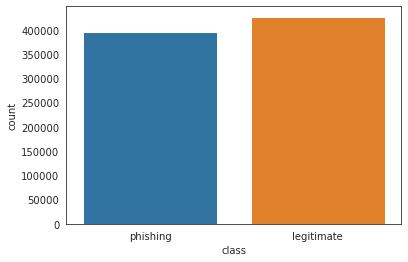

In [ ]:
sns.countplot(data['class'])

In [ ]:
data.loc[data['is_IP']==1]

,url,status,url_length,class,num_special_chars,num_subdomains,num_digits,num_dots,num_slash,num_and,num_percent,top_domain,domain,domain_length,num_digits_in_domain,is_IP,is_HTTPS,depth
92,103.114.104.87,0,14,phishing,0,2,11,3,0,0,0,0,103.114.1042,12,10,1,0,1
93,103.119.0.224,0,13,phishing,0,2,10,3,0,0,0,0,103.119.02,10,8,1,0,1
94,103.119.30.176,0,14,phishing,0,2,11,3,0,0,0,0,103.119.302,11,9,1,0,1
95,103.195.100.74,0,14,phishing,0,2,11,3,0,0,0,0,103.195.1002,12,10,1,0,1
96,103.195.7.246,0,13,phishing,0,2,10,3,0,0,0,0,103.195.72,10,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751914,94.177.203.169,0,14,phishing,0,2,11,3,0,0,0,0,94.177.2032,11,9,1,0,1
751915,94.177.242.164,0,14,phishing,0,2,11,3,0,0,0,0,94.177.2422,11,9,1,0,1
751916,94.177.250.193,0,14,phishing,0,2,11,3,0,0,0,0,94.177.2502,11,9,1,0,1
751917,94.177.254.180,0,14,phishing,0,2,11,3,0,0,0,0,94.177.2542,11,9,1,0,1


In [ ]:
data.describe()

,status,url_length,num_special_chars,num_subdomains,num_digits,num_dots,num_slash,num_and,num_percent,domain_length,num_digits_in_domain,is_IP,is_HTTPS,depth
count,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000,822010.000000
mean,0.519492,47.089759,1.341099,1.132614,3.985646,2.132614,2.501928,0.105501,0.075775,11.019400,0.606255,0.002029,0.161550,2.362101
std,0.499620,42.556044,2.505930,1.505595,10.932098,1.505595,1.852917,0.733197,1.167017,11.958101,3.417176,0.045001,0.368038,1.783668
min,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,26.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,37.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,55.000000,2.000000,1.000000,4.000000,2.000000,3.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,3992.000000,197.000000,36.000000,1575.000000,37.000000,51.000000,37.000000,253.000000,246.000000,134.000000,1.000000,1.000000,35.000000


In [ ]:
data.top_domain.describe()

count     822010
unique      1873
top          com
freq      473795
Name: top_domain, dtype: object

In [ ]:
data[data['status']==0].top_domain.describe()

count     394982
unique      1737
top          com
freq      160422
Name: top_domain, dtype: object

In [ ]:
data[data['status']==1].top_domain.describe()

count     427028
unique       389
top          com
freq      313373
Name: top_domain, dtype: object

In [ ]:
data[data['status']==0].top_domain.value_counts()[:10]

com     160422
cn       38035
org      21560
net      15564
top      12637
ru        7233
br        6939
xyz       6251
info      5515
shop      5088
Name: top_domain, dtype: int64

In [ ]:
data[data['status']==1].top_domain.value_counts()[:10]

com    313373
org     46700
net     15723
edu     10814
ca      10119
uk       6977
gov      3330
au       1935
de       1518
us       1468
Name: top_domain, dtype: int64

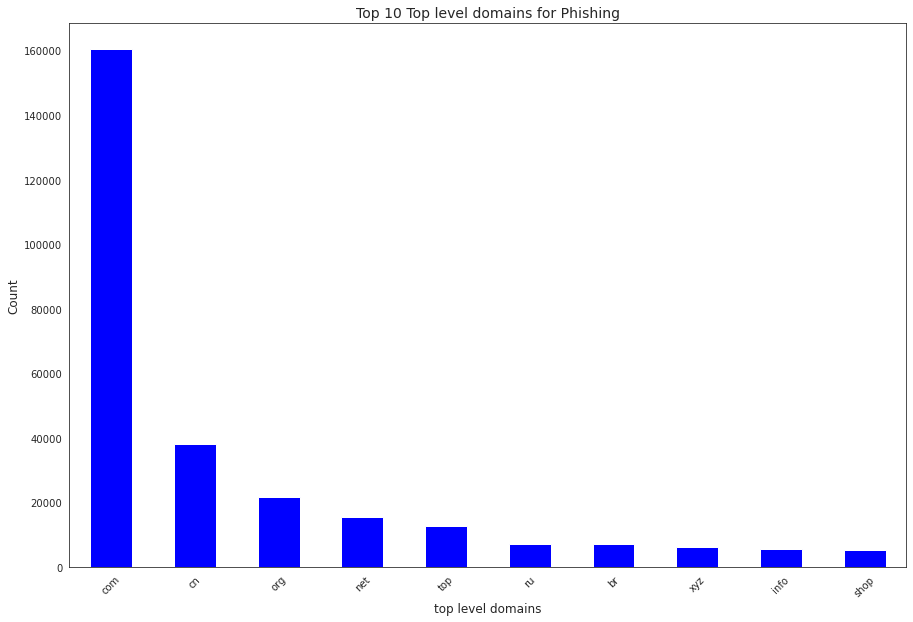

<Figure size 0x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==0].top_domain.value_counts()[:10].plot.bar(color='blue', ax=ax )
plt.title('Top 10 Top level domains for Phishing',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()


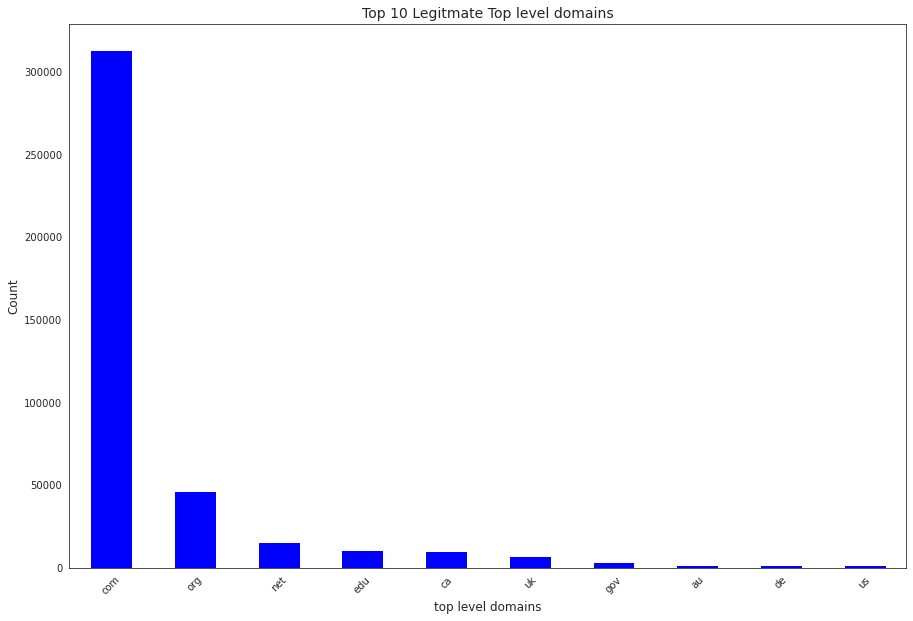

<Figure size 0x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==1].top_domain.value_counts()[:10].plot.bar(color='blue', ax=ax )
plt.title('Top 10 Legitmate Top level domains',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

In [ ]:
data.domain

In [ ]:
data[data['status']==0].domain.describe()

In [ ]:
data[data['status']==1].domain.describe()

In [ ]:
# data[data['status']==0].domain.value_counts()[:10] 

In [ ]:
data[data['domain']=='https://rebrand']

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==0].domain.value_counts()[:10].plot.bar(color='blue', ax=ax)
plt.title('Top 10 Domains for Phishing',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
data[data['status']==1].domain.value_counts()[:10].plot.bar(color='blue', ax=ax)
plt.title('Top 10 Legitmate Domains',size=14)
plt.xlabel('top level domains',size=12)
plt.ylabel('Count',size=12)
plt.xticks(rotation=45)
plt.figure().set_figwidth(0)
plt.show()

In [ ]:
data.is_HTTPS.sum()

In [ ]:
labels=["HTTPS","Http",'IP Address']
ht=data.is_HTTPS.sum()
ip=data.is_IP.sum()
h=data.loc[(data['is_HTTPS']==0)&(data['is_IP']==0)]
y=[ht,len(h),ip]
plt.figure(figsize=plt.figaspect(1))
fig = plt.figure(figsize=(15,30))
ax = fig.add_axes((0,0,.5,1))
ax.set_title('Distribution of Protocols')
plt.pie(y, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(y)/100 :.0f}') 


In [ ]:
grouped_data = data.groupby(['url_length', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='url_length', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of dots in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:
grouped_data = data.groupby(['domain_length', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='domain_length', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Length of Domain")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:
grouped_data = data.groupby(['num_dots', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_dots', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of dots in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:

grouped_data = data.groupby(['num_digits', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_digits', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Digits in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)


In [ ]:

grouped_data = data.groupby(['num_subdomains', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_subdomains', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of subdomains in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)



In [ ]:
grouped_data = data.groupby(['num_special_chars', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_special_chars', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Special Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)


In [ ]:
grouped_data = data.groupby(['num_slash', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_slash', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Slash Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:
grouped_data = data.groupby(['num_and', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_and', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of & Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:
grouped_data = data.groupby(['num_percent', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='num_percent', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of % Characters in URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:
grouped_data = data.groupby(['depth', 'class']).size().reset_index(name='count')
p=sns.lineplot(x='depth', y='count', hue='class', data=grouped_data, marker='o')
p.set_title("Number of Depth of URL")
p.figure.set_figwidth(17)
p.figure.set_figheight(11.7)

In [ ]:
data

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['top_domain_encoded'] = label_encoder.fit_transform(data['top_domain'])

In [ ]:
data.head()